In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
import re

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Datasets

https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection <br>
https://github.com/bshmueli/SPIRS <br>
https://github.com/soraby/sarcasm2 <br>

# News headlines

In [15]:
# !pip install -q kaggle

# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"lisanvo13","key":"c12fa77a8c7ef1c3f5a9a56c751ac750"}'}

In [19]:
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [20]:
# !kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          17013        372  1.0              
bhadramohit/world-bank-dataset                               World Bank Dataset                               5KB  2024-10-20 14:57:06           1530         27  1.0              
bhadramohit/smartphone-usage-and-behavioral-dataset          Smartphone Usage and Behavioral Dataset         17KB  2024-10-23 03:16:02           1519         31  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset           

In [22]:
#!/bin/bash
!kaggle datasets download "rmisra/news-headlines-dataset-for-sarcasm-detection"

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 171MB/s]


In [27]:
# Unzip data
!mkdir "/content/news-headlines-dataset"
!unzip "/content/news-headlines-dataset-for-sarcasm-detection.zip" -d "/content/news-headlines-dataset"

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: /content/news-headlines-dataset/Sarcasm_Headlines_Dataset.json  
  inflating: /content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json  


In [28]:
# Read JSON file into DataFrame
df = pd.read_json("/content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [46]:
df.dtypes

,0
is_sarcastic,int64
headline,object
article_link,object
mean_word_length,float64


In [30]:
# Check for NaN values
df.isnull().sum()

,0
is_sarcastic,0
headline,0
article_link,0


In [31]:
# Check for class imbalance
df["is_sarcastic"].value_counts()

,count
is_sarcastic,
0,14985
1,13634


In [32]:
# Check character count of a headline
length = len(df['headline'][0])
print(f'Length of a sample headline: {length}')

Length of a sample headline: 61


In [33]:
# Check word count
word_count = df['headline'][0].split()
print(f'Word count in a sample headline: {len(word_count)}')

Word count in a sample headline: 8


In [34]:
# Calculate mean word length
df['mean_word_length'] = df['headline'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,is_sarcastic,headline,article_link,mean_word_length
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,6.750000
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,5.153846
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,6.142857
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,5.625000
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,5.888889
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,6.000000
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...,3.777778
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...,5.846154
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...,5.166667
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...,4.833333


In [40]:
# Calculate mean sentence length
np.mean([len(headline) for headline in tokenize.sent_tokenize(df['headline'][0])])

61.0

In [41]:
# Most Frequently occuring N_grams
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['headline'])

In [42]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

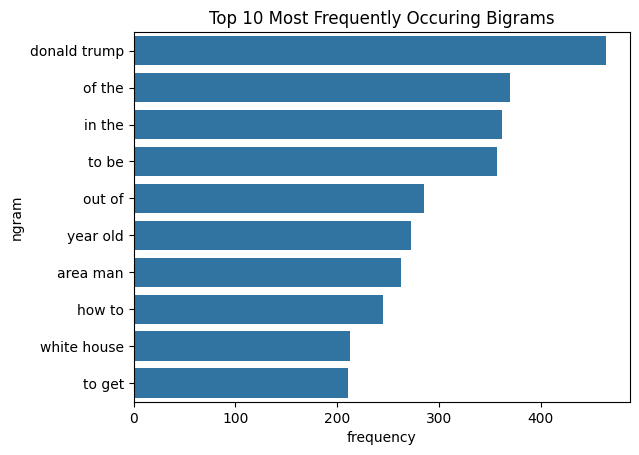

In [43]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [44]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

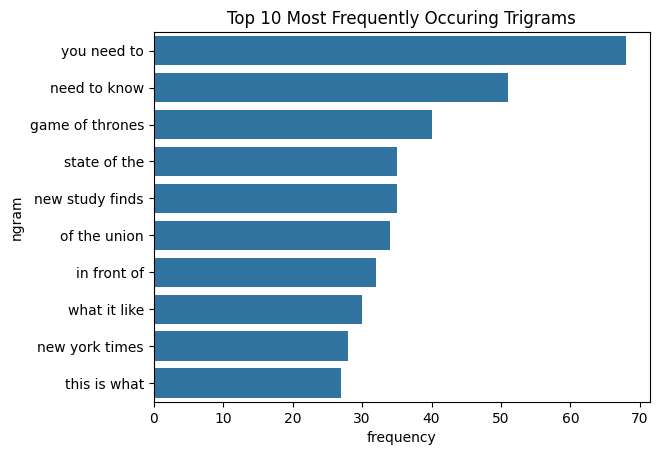

In [45]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [47]:
# Get all rows where is_sarcastic is 1
df_sarcastic = df[df['is_sarcastic'] == 1]
df_sarcastic.head()

# Get all rows where is_sarcastic is 0
df_not_sarcastic = df[df['is_sarcastic'] == 0]
df_not_sarcastic.head()

,is_sarcastic,headline,article_link,mean_word_length
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,5.153846
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,6.142857
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,6.000000
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...,3.777778
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...,4.833333


## Most Frequently occuring N_grams (SARCASTIC)

In [48]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sarcastic['headline'])

In [49]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

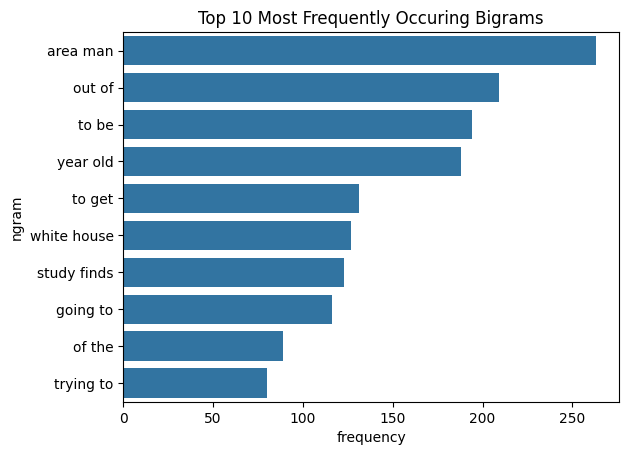

In [50]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [53]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

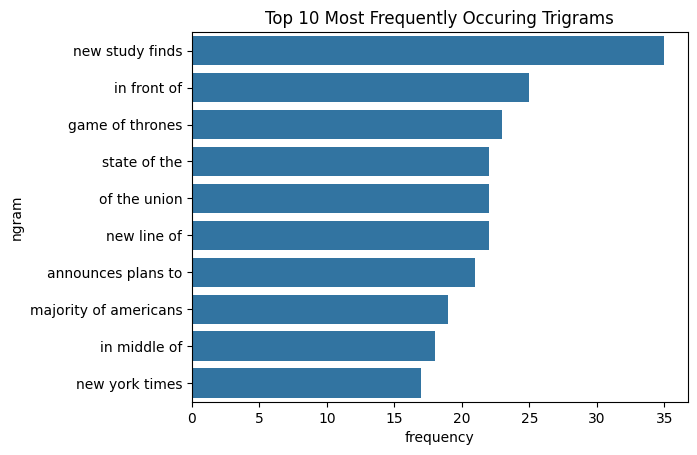

In [54]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

## Most Frequently occuring N_grams (NOT SARCASTIC)

In [55]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_not_sarcastic['headline'])

In [56]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

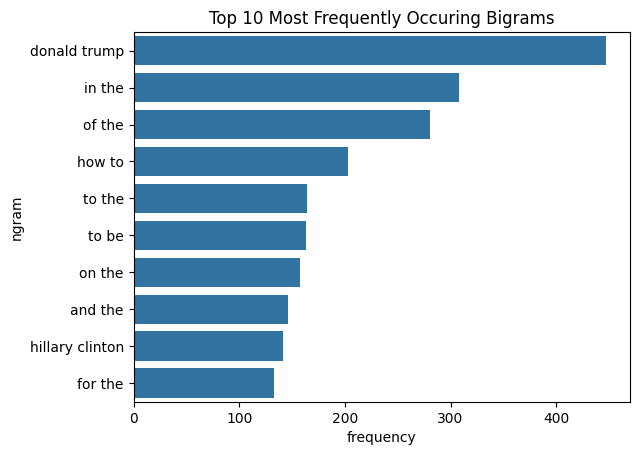

In [57]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [58]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_not_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

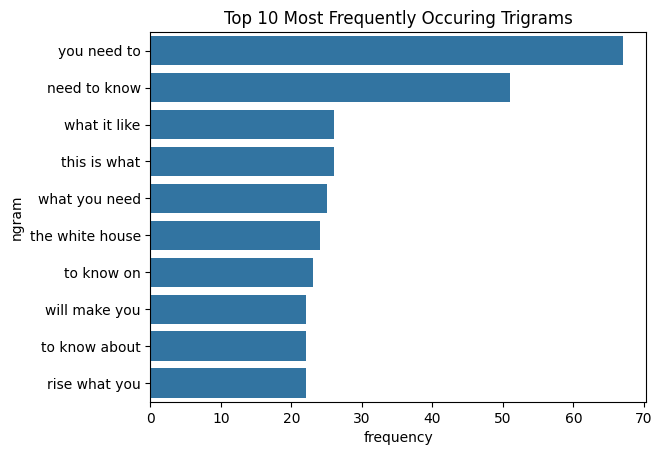

In [59]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

# Sarcasm Corpus V2

In [60]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/aai590-capstone/sarcasm_v2/GEN-sarc-notsarc.csv")
df.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


In [61]:
# Check for NaN values
df.isnull().sum()

,0
class,0
id,0
text,0


In [64]:
# Check for class imbalance
df["class"].value_counts()

,count
class,
notsarc,3260
sarc,3260


In [65]:
# Check character count of a headline
length = len(df['text'][0])
print(f'Length of a sample headline: {length}')

Length of a sample headline: 156


In [66]:
# Check word count
word_count = df['text'][0].split()
print(f'Word count in a sample headline: {len(word_count)}')

Word count in a sample headline: 30


In [67]:
# Calculate mean word length
df['mean_word_length'] = df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,class,id,text,mean_word_length
0,notsarc,1,"If that's true, then Freedom of Speech is doom...",4.233333
1,notsarc,2,Neener neener - is it time to go in from the p...,3.692308
2,notsarc,3,"Just like the plastic gun fear, the armour pie...",5.117647
3,notsarc,4,So geology is a religion because we weren't he...,4.071429
4,notsarc,5,Well done Monty. Mark that up as your first ev...,4.312500
5,notsarc,6,But the whole process was done in the courts u...,4.340000
6,notsarc,7,so we would penalize financially those who wan...,4.636364
7,notsarc,8,"So, IOW, you are saying that those of us who a...",4.702703
8,notsarc,9,your probably referring to the mexican basin c...,5.016129
9,notsarc,10,"Not in matters of atheism. Tell me, when scien...",4.717949


In [68]:
# Calculate mean sentence length
np.mean([len(text) for text in tokenize.sent_tokenize(df['text'][0])])

51.333333333333336

In [69]:
# Most Frequently occuring N_grams
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['text'])

In [70]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

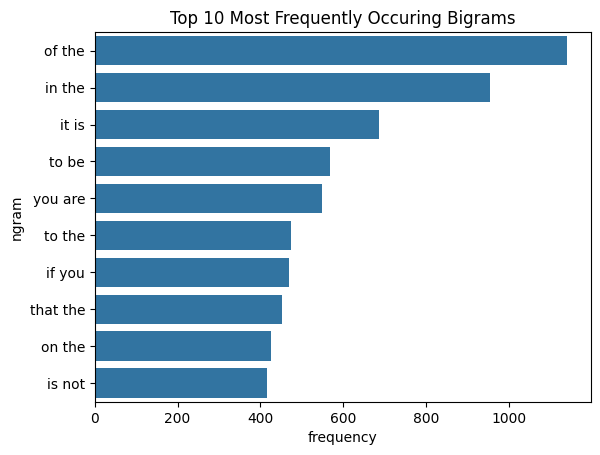

In [71]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [72]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

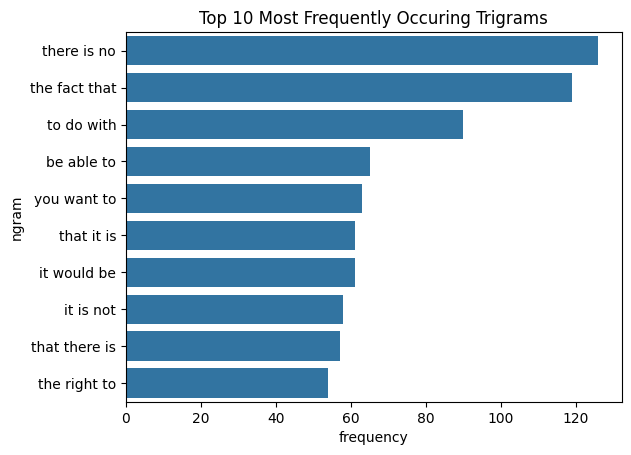

In [73]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()